All code taken from:

https://www.datacamp.com/community/tutorials/lstm-python-stock-market

for learning purposes.

In [1]:
import requests
from pandas_datareader import data
from matplotlib import pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import torch as t
from sklearn.preprocessing import MinMaxScaler


In [11]:
data_source = 'alphavantage' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = open("APICode.txt").read()

    # American Airlines stock market prices
    ticker = "IBM"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_Daily&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            print(data)
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

df = df.sort_values("Date")

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'IBM', '3. Last Refreshed': '2021-08-05', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2021-08-05': {'1. open': '143.0300', '2. high': '143.4100', '3. low': '142.2200', '4. close': '142.7700', '5. volume': '2757389'}, '2021-08-04': {'1. open': '143.8000', '2. high': '144.1800', '3. low': '142.4700', '4. close': '142.7600', '5. volume': '2830079'}, '2021-08-03': {'1. open': '141.9000', '2. high': '144.7000', '3. low': '141.6500', '4. close': '144.0700', '5. volume': '4084724'}, '2021-08-02': {'1. open': '141.4500', '2. high': '143.0600', '3. low': '141.0300', '4. close': '141.4200', '5. volume': '2929540'}, '2021-07-30': {'1. open': '141.5200', '2. high': '141.8500', '3. low': '140.7900', '4. close': '140.9600', '5. volume': '3535555'}, '2021-07-29': {'1. open': '142.3300', '2. high': '142.9600', '3. low': '141.6000', '4. close': '141.9300', '5. vo

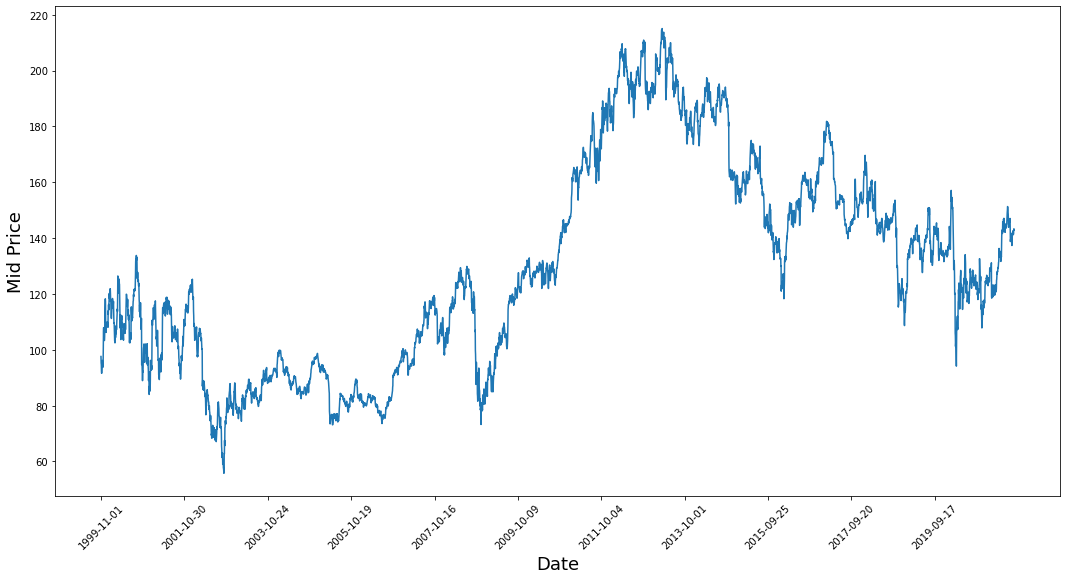

In [12]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [37]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

train_data = mid_prices[::2]
test_data = mid_prices[1::2]

# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [38]:
di=0
# Train the Scaler with training data and smooth data
smoothing_window_size = 800
for di in range(0,2400,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [39]:
# Reshape both train and test data
train_data = train_data.reshape(-1)
# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [40]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(2700):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

